## Author: SUBHANI SHAIK -MT18117

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy,pickle,glob,warnings
from prettytable import PrettyTable

from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,f1_score,precision_score,recall_score,precision_recall_curve,matthews_corrcoef

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier

from sklearn.decomposition import TruncatedSVD
from genetic_selection import GeneticSelectionCV
from copy import deepcopy

warnings.filterwarnings('ignore')

In [2]:
def draw_roc(y_actual, scores, title=''):# to draw roc curve
    fpr, tpr, thresholds = roc_curve(y_actual, scores, pos_label=1)
    auroc_value = auc(fpr, tpr)

    plt.plot(fpr,tpr, label = 'AUC: '+str(round(auroc_value, 4)))
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR = 1-Specificity')
    plt.ylabel("TPR = Recall = Sensitivity")
    plt.title("AUC-ROC Curve: " + title)
    plt.legend(loc = 'lower right')
    plt.savefig(title+'-ROC')
    return auroc_value
    
def metric(y_test, y_pred,scores, title=''): # metrics evaluation
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity, acc, f1, precision, recall, mcc = tn/(tn + fp) ,accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), matthews_corrcoef(y_test, y_pred)
    
    x,metric_list = PrettyTable(), []
    
    x.field_names = ["Evaluation Metric", "Score"]; 
    x.add_row(["Accuracy", round(acc, 4)]); metric_list.append(["Accuracy",round(acc, 4)])
    x.add_row(["F1-score", round(f1, 4)]); metric_list.append(['F1-score',round(f1, 4)])
    x.add_row(["Precision", round(precision, 4)]); metric_list.append(['Precision', round(precision, 4)])
    x.add_row(["Recall", round(recall, 4)]); metric_list.append(["Recall", round(recall, 4)])
    x.add_row(["Specificity", round(specificity, 4)]); metric_list.append(["Specificity", round(specificity, 4)])
    x.add_row(["MCC", round(mcc, 4)]); metric_list.append(["MCC", round(mcc, 4)])
    
    auroc_value = draw_roc(y_test,scores, title)
    x.add_row(["AUROC value", round(auroc_value, 4)]); metric_list.append(["AUROC value", round(auroc_value, 4)])
    
    print(x);plt.show()
    print('--------------------------------------------------------------\n\n\n')
    return metric_list

### Models

In [3]:
# respective models with parameters
def model_logistic_regression(X_train, X_test, y_train, y_test):
    tuned_parameters = [{'C': [10**-4, 10**-2, 10**-1, 10**0,10**1, 10**2, 10**4]}]
    logistic_model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
    logistic_model.fit(X_train, y_train)

    logistic_train_pred, logistic_test_pred = logistic_model.predict(X_train), logistic_model.predict(X_test)
    logistic_train_scores, logistic_test_scores = logistic_model.predict_proba(X_train)[:,1], logistic_model.predict_proba(X_test)[:,1]

    print('Logistic Regression')
    logistic_metric_list_train, logistic_metric_list_test = metric(y_train, logistic_train_pred, logistic_train_scores, 'Logistic Regression(Train metrics)'),\
                                                            metric(y_test, logistic_test_pred, logistic_test_scores, 'Logistic Regression(Test metrics)')

    return logistic_model, logistic_metric_list_train, logistic_metric_list_test

def model_rbfsvm(X_train, X_test, y_train, y_test):
    
    Cs = [0.001, 0.01, 0.1, 1, 10,100,1000]
    gammas = [0.0001,0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}

    rbfsvm_model = GridSearchCV(SVC(kernel='rbf',probability=True), param_grid, cv=5)
    rbfsvm_model.fit(X_train, y_train)

    rbfsvm_train_pred, rbfsvm_test_pred = rbfsvm_model.predict(X_train), rbfsvm_model.predict(X_test)

    rbfsvm_train_scores, rbfsvm_test_scores = rbfsvm_model.predict_proba(X_train)[:,1], rbfsvm_model.predict_proba(X_test)[:,1]

    print('SVM(kernel=RBF) classifier')
    rbfsvm_metric_list_train, rbfsvm_metric_list_test = metric(y_train, rbfsvm_train_pred, rbfsvm_train_scores, 'SVM(Train metrics)'),\
                                                        metric(y_test, rbfsvm_test_pred, rbfsvm_test_scores, 'SVM (Test metrics)')

    return rbfsvm_model, rbfsvm_metric_list_train, rbfsvm_metric_list_test

def model_dTree_1(X_train, X_test, y_train, y_test):
    depth = np.linspace(1, 15, 15, endpoint=True)
    min_split = np.linspace(0.5, 1.0, 10, endpoint=True)
    min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
    max_feat = list(range(1,X_train.shape[1]))
    param_grid = {'max_depth': depth, 'min_samples_split' : min_split,'min_samples_leaf' : min_samples_leaf,'max_features' : max_feat}

    dtree_model = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
    dtree_model.fit(X_train, y_train)

    dtree_train_pred, dtree_test_pred = dtree_model.predict(X_train), dtree_model.predict(X_test)
    dtree_train_scores, dtree_test_scores = dtree_model.predict_proba(X_train)[:,1], dtree_model.predict_proba(X_test)[:,1]

    print('DecisionTree classifier')
    dtree_metric_list_train, dtree_metric_list_test = metric(y_train, dtree_train_pred, dtree_train_scores, 'DecisionTree(Train metrics)'),\
                                                    metric(y_test, dtree_test_pred, dtree_test_scores, 'DecisionTree(Test metrics)')

    return dtree_model, dtree_metric_list_train, dtree_metric_list_test

def model_dTree_2(X_train, X_test, y_train, y_test):
    depth = np.linspace(1, 15, 15, endpoint=True)
#     min_split = np.linspace(0.5, 1.0, 10, endpoint=True)
#     min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
    max_feat = list(range(1,X_train.shape[1]))
#     param_grid = {'max_depth': depth, 'min_samples_split' : min_split,'min_samples_leaf' : min_samples_leaf,'max_features' : max_feat}
    param_grid = {'max_depth': depth,'max_features' : max_feat}
    dtree_model = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
    dtree_model.fit(X_train, y_train)

    dtree_train_pred, dtree_test_pred = dtree_model.predict(X_train), dtree_model.predict(X_test)
    dtree_train_scores, dtree_test_scores = dtree_model.predict_proba(X_train)[:,1], dtree_model.predict_proba(X_test)[:,1]

    print('DecisionTree classifier')
    dtree_metric_list_train, dtree_metric_list_test = metric(y_train, dtree_train_pred, dtree_train_scores, 'DecisionTree(Train metrics)'),\
                                                    metric(y_test, dtree_test_pred, dtree_test_scores, 'DecisionTree(Test metrics)')

    return dtree_model, dtree_metric_list_train, dtree_metric_list_test

def model_dTree_3(X_train, X_test, y_train, y_test):
    dtree_model = DecisionTreeClassifier()
    dtree_model.fit(X_train, y_train)

    dtree_train_pred, dtree_test_pred = dtree_model.predict(X_train), dtree_model.predict(X_test)
    dtree_train_scores, dtree_test_scores = dtree_model.predict_proba(X_train)[:,1], dtree_model.predict_proba(X_test)[:,1]

    print('DecisionTree classifier')
    dtree_metric_list_train, dtree_metric_list_test = metric(y_train, dtree_train_pred, dtree_train_scores, 'DecisionTree(Train metrics)'),\
                                                    metric(y_test, dtree_test_pred, dtree_test_scores, 'DecisionTree(Test metrics)')

    return dtree_model, dtree_metric_list_train, dtree_metric_list_test

def model_mlp(X_train, X_test, y_train, y_test, layer1, layer2):
    mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(layer1,layer2), random_state=42)
    mlp_model.fit(X_train, y_train)

    mlp_train_pred, mlp_test_pred = mlp_model.predict(X_train), mlp_model.predict(X_test)
    mlp_train_scores, mlp_test_scores = mlp_model.predict_proba(X_train)[:,1], mlp_model.predict_proba(X_test)[:,1]

    print('MLP classifier')
    mlp_metric_list_train, mlp_metric_list_test = metric(y_train, mlp_train_pred, mlp_train_scores, 'MLP(Train metrics)'),\
                                                    metric(y_test, mlp_test_pred, mlp_test_scores, 'MLP(Test metrics)')

    return mlp_model, mlp_metric_list_train, mlp_metric_list_test

def model_random_forest_1(X_train, X_test, y_train, y_test):
    depth = np.linspace(1, 32, 32, endpoint=True)
    min_split = np.linspace(0.1, 1.0, 10, endpoint=True)
    min_samples_lef = np.linspace(0.1, 0.5, 5, endpoint=True)
    est = [20,21,22,23,24,25,26]
    param_grid = {'n_estimators' : est,'max_depth': depth, 'min_samples_split' : min_split,'min_samples_leaf' : min_samples_lef}
    rf_model = GridSearchCV(RandomForestClassifier(), param_grid, cv=2,n_jobs=-1)
    rf_model.fit(X_train, y_train)

    rf_train_pred, rf_test_pred = rf_model.predict(X_train), rf_model.predict(X_test)
    rf_train_scores, rf_test_scores = rf_model.predict_proba(X_train)[:,1], rf_model.predict_proba(X_test)[:,1]

    print('Random Forest classifier')
    rf_metric_list_train, rf_metric_list_test = metric(y_train, rf_train_pred, rf_train_scores, 'Random Forest(Train)'),\
                                                metric(y_test, rf_test_pred, rf_test_scores, 'Random Forest(Test)')
    
    return rf_model, rf_metric_list_train, rf_metric_list_test

def model_random_forest_2(X_train, X_test, y_train, y_test):
    depth = np.linspace(1, 32, 32, endpoint=True)
    est = [20,21,22,23,24]
    param_grid = {'n_estimators' : est,'max_depth': depth}
    rf_model = GridSearchCV(RandomForestClassifier(), param_grid, cv=2,n_jobs=-1)
    rf_model.fit(X_train, y_train)

    rf_train_pred, rf_test_pred = rf_model.predict(X_train), rf_model.predict(X_test)
    rf_train_scores, rf_test_scores = rf_model.predict_proba(X_train)[:,1], rf_model.predict_proba(X_test)[:,1]

    print('Random Forest classifier')
    rf_metric_list_train, rf_metric_list_test = metric(y_train, rf_train_pred, rf_train_scores, 'Random Forest(Train)'),\
                                                metric(y_test, rf_test_pred, rf_test_scores, 'Random Forest(Test)')
    
    return rf_model, rf_metric_list_train, rf_metric_list_test

def model_random_forest_3(X_train, X_test, y_train, y_test):
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    rf_train_pred, rf_test_pred = rf_model.predict(X_train), rf_model.predict(X_test)
    rf_train_scores, rf_test_scores = rf_model.predict_proba(X_train)[:,1], rf_model.predict_proba(X_test)[:,1]

    print('Random Forest classifier')
    rf_metric_list_train, rf_metric_list_test = metric(y_train, rf_train_pred, rf_train_scores, 'Random Forest(Train)'),\
                                                metric(y_test, rf_test_pred, rf_test_scores, 'Random Forest(Test)')
    
    return rf_model, rf_metric_list_train, rf_metric_list_test

### Loading Data

In [4]:
complete_X_train = pd.read_csv('outputs/B/MT18117_q5_X_train.csv')
complete_X_test = pd.read_csv('outputs/B/MT18117_q5_X_test.csv')
complete_Y_train = pd.read_csv('outputs/B/MT18117_q5_Y_train.csv',names=['Group'])
complete_Y_test = pd.read_csv('outputs/B/MT18117_q5_Y_test.csv',names=['Group'])

excluded_features_train = pd.read_csv('outputs/B/MT18117_q5_excluded_features_train.csv')
excluded_features_test = pd.read_csv('outputs/B/MT18117_q5_excluded_features_test.csv')

y_train, y_test = complete_Y_train.values, complete_Y_test.values

# X with excluded features

In [5]:
X_train_excluded, X_test_excluded = complete_X_train.values, complete_X_test.values

#### Normalizing

In [6]:
X_train_excluded, X_test_excluded = scale(X_train_excluded), scale(X_test_excluded)

### Logistic Regression

Logistic Regression
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8113 |
|      F1-score     | 0.8786 |
|     Precision     | 0.8498 |
|       Recall      | 0.9095 |
|    Specificity    | 0.5152 |
|        MCC        | 0.4625 |
|    AUROC value    | 0.8716 |
+-------------------+--------+


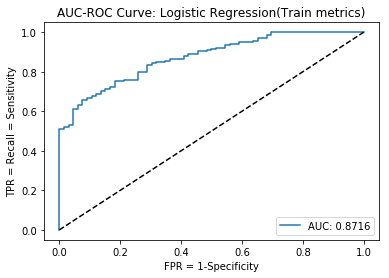

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.687  |
|      F1-score     | 0.7978 |
|     Precision     | 0.7717 |
|       Recall      | 0.8256 |
|    Specificity    | 0.2759 |
|        MCC        | 0.1101 |
|    AUROC value    | 0.6584 |
+-------------------+--------+


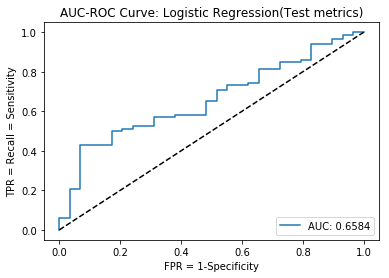

--------------------------------------------------------------





In [7]:
logistic_model_excluded, logistic_excluded_metric_list_train, logistic_excluded_metric_list_test = model_logistic_regression(X_train_excluded, X_test_excluded, y_train, y_test)

### SVM

SVM(kernel=RBF) classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


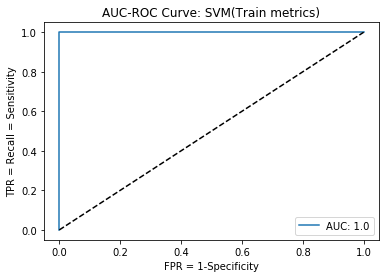

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8087 |
|      F1-score     | 0.8842 |
|     Precision     | 0.8077 |
|       Recall      | 0.9767 |
|    Specificity    | 0.3103 |
|        MCC        | 0.4239 |
|    AUROC value    | 0.7326 |
+-------------------+--------+


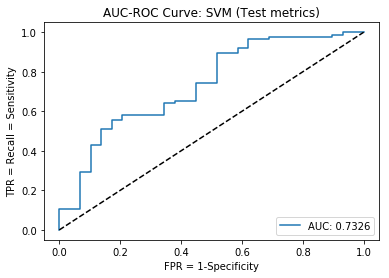

--------------------------------------------------------------





In [8]:
rbfsvm_excluded_model, rbfsvm_excluded_metric_list_train, rbfsvm_excluded_metric_list_test = model_rbfsvm(X_train_excluded, X_test_excluded, y_train, y_test)

### Decision Trees

DecisionTree classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


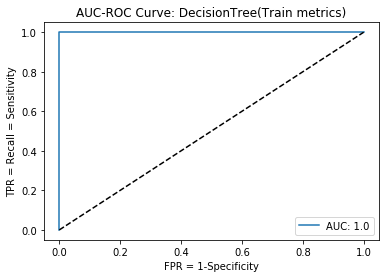

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.6435 |
|      F1-score     | 0.763  |
|     Precision     | 0.7586 |
|       Recall      | 0.7674 |
|    Specificity    | 0.2759 |
|        MCC        | 0.0438 |
|    AUROC value    | 0.5217 |
+-------------------+--------+


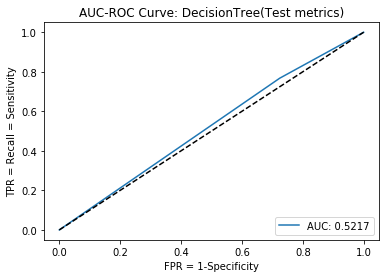

--------------------------------------------------------------





In [9]:
# dtree_excluded_model_1, dtree_excluded_metric_list_train_1, dtree_excluded_metric_list_test_1 = model_dTree_1(X_train_excluded, X_test_excluded, y_train, y_test)

# dtree_excluded_model_2, dtree_excluded_metric_list_train_2, dtree_excluded_metric_list_test_2 = model_dTree_2(X_train_excluded, X_test_excluded, y_train, y_test)

dtree_excluded_model_3, dtree_excluded_metric_list_train_3, dtree_excluded_metric_list_test_3 = model_dTree_3(X_train_excluded, X_test_excluded, y_train, y_test)

### MLP

MLP classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


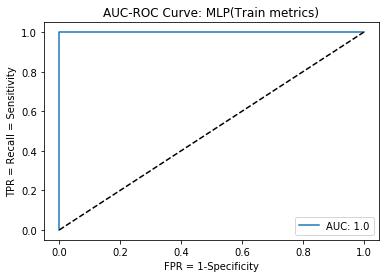

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.7391 |
|      F1-score     | 0.8214 |
|     Precision     | 0.8415 |
|       Recall      | 0.8023 |
|    Specificity    | 0.5517 |
|        MCC        | 0.3399 |
|    AUROC value    | 0.743  |
+-------------------+--------+


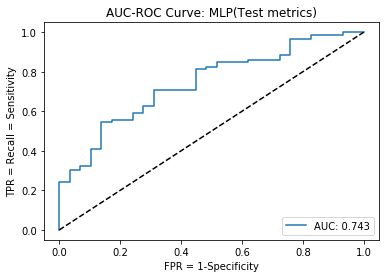

--------------------------------------------------------------





In [10]:
layer1, layer2 = 150,150
mlp_excluded_model, mlp_excluded_metric_list_train, mlp_excluded_metric_list_test = model_mlp(X_train_excluded, X_test_excluded, y_train, y_test, layer1, layer2)

### Random Forest

Random Forest classifier
+-------------------+-------+
| Evaluation Metric | Score |
+-------------------+-------+
|      Accuracy     |  1.0  |
|      F1-score     |  1.0  |
|     Precision     |  1.0  |
|       Recall      |  1.0  |
|    Specificity    |  1.0  |
|        MCC        |  1.0  |
|    AUROC value    |  1.0  |
+-------------------+-------+


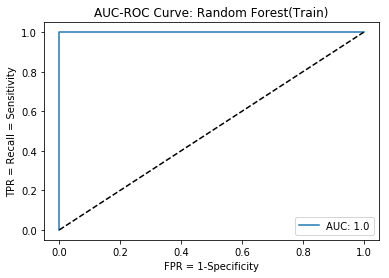

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.7217 |
|      F1-score     | 0.8202 |
|     Precision     | 0.7935 |
|       Recall      | 0.8488 |
|    Specificity    | 0.3448 |
|        MCC        | 0.2103 |
|    AUROC value    | 0.6433 |
+-------------------+--------+


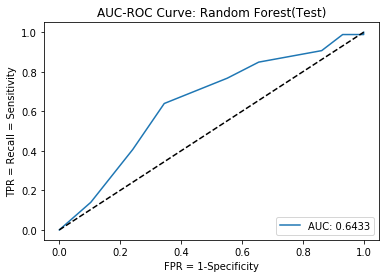

--------------------------------------------------------------





In [11]:
# rf_excluded_model_1, rf_excluded_metric_list_train_1, rf_excluded_metric_list_test_1 = model_random_forest_1(X_train_excluded, X_test_excluded, y_train, y_test)

# rf_excluded_model_2, rf_excluded_metric_list_train_2, rf_excluded_metric_list_test_2 = model_random_forest_2(X_train_excluded, X_test_excluded, y_train, y_test)

rf_excluded_model_3, rf_excluded_metric_list_train_3, rf_excluded_metric_list_test_3 = model_random_forest_3(X_train_excluded, X_test_excluded, y_train, y_test)

### ====================================================================

In [12]:
# # X+GA

# X_train_GA, X_test_GA = deepcopy(complete_X_train),deepcopy(complete_X_test)

# X_train_GA = pd.concat([X_train_GA,excluded_features_train['GA']],axis=1)
# X_test_GA = pd.concat([X_test_GA,excluded_features_test['GA']],axis=1)

# X_train_GA, X_test_GA = X_train_GA.values, X_test_GA.values

# #### Normalizing

# X_train_GA, X_test_GA = scale(X_train_GA), scale(X_test_GA)

# ### Logistic regression

# logistic_GA_model, logistic_GA_metric_list_train, logistic_GA_metric_list_test  = model_logistic_regression(X_train_GA, X_test_GA,y_train, y_test)

# ### SVM

# rbfsvm_GA_model, rbfsvm_GA_metric_list_train, rbfsvm_GA_metric_list_test = model_rbfsvm(X_train_GA, X_test_GA,y_train, y_test)

# ### Decision Tree

# # dtree_GA_model_1, dtree_GA_metric_list_train_1, dtree_GA_metric_list_test_1 = model_dTree_2(X_train_GA, X_test_GA,y_train, y_test)

# # dtree_GA_model_2, dtree_GA_metric_list_train_2, dtree_GA_metric_list_test_2 = model_dTree_2(X_train_GA, X_test_GA,y_train, y_test)

# dtree_GA_model_3, dtree_GA_metric_list_train_3, dtree_GA_metric_list_test_3 = model_dTree_3(X_train_GA, X_test_GA,y_train, y_test)

# ### MLP

# layer1, layer2 = 151,151
# mlp_GA_model, mlp_GA_metric_list_train, mlp_GA_metric_list_test = model_mlp(X_train_GA, X_test_GA, y_train, y_test, layer1, layer2)

# ### Random Forest

# # rf_GA_model_1, rf_GA_metric_list_train_1, rf_GA_metric_list_test_1 = model_random_forest_1(X_train_GA, X_test_GA,y_train, y_test)

# # rf_GA_model_2, rf_GA_metric_list_train_2, rf_GA_metric_list_test_2 = model_random_forest_2(X_train_GA, X_test_GA,y_train, y_test)

# rf_GA_model_3, rf_GA_metric_list_train_3, rf_GA_metric_list_test_3 = model_random_forest_3(X_train_GA, X_test_GA,y_train, y_test)

# ### ====================================================================

# # X+GADel

# X_train_GADel, X_test_GADel = deepcopy(complete_X_train),deepcopy(complete_X_test)

# X_train_GADel = pd.concat([X_train_GADel,excluded_features_train['GADel']],axis=1)
# X_test_GADel  = pd.concat([X_test_GADel,excluded_features_test['GADel']],axis=1)

# X_train_GADel, X_test_GADel = X_train_GADel.values, X_test_GADel.values

# #### Normalizing

# X_train_GADel, X_test_GADel = scale(X_train_GADel), scale(X_test_GADel)

# ### Logistic regression

# logistic_GADel_model, logistic_GADel_metric_list_train, logistic_GADel_metric_list_test = model_logistic_regression(X_train_GADel, X_test_GADel,y_train, y_test)

# ### SVM

# rbfsvm_GADel_model, rbfsvm_GADel_metric_list_train, rbfsvm_GADel_metric_list_test = model_rbfsvm(X_train_GADel, X_test_GADel,y_train, y_test)

# ### Decision Tree

# # dtree_GADel_model_1, dtree_GADel_metric_list_train_1, dtree_GADel_metric_list_test_1 = model_dTree_1(X_train_GADel, X_test_GADel,y_train, y_test)

# # dtree_GADel_model_2, dtree_GADel_metric_list_train_2, dtree_GADel_metric_list_test_2 = model_dTree_2(X_train_GADel, X_test_GADel,y_train, y_test)

# dtree_GADel_model_3, dtree_GADel_metric_list_train_3, dtree_GADel_metric_list_test_3 = model_dTree_3(X_train_GADel, X_test_GADel,y_train, y_test)

# ### MLP

# layer1, layer2 = 151, 151
# mlp_GADel_model, mlp_GADel_metric_list_train, mlp_GADel_metric_list_test = model_mlp(X_train_GADel, X_test_GADel,y_train, y_test, layer1, layer2)

# ### Random Forest

# # rf_GADel_model_1, rf_GADel_metric_list_train_1, rf_GADel_metric_list_test_1 = model_random_forest_1(X_train_GADel, X_test_GADel,y_train, y_test)

# # rf_GADel_model_2, rf_GADel_metric_list_train_2, rf_GADel_metric_list_test_2 = model_random_forest_2(X_train_GADel, X_test_GADel,y_train, y_test)

# rf_GADel_model_3, rf_GADel_metric_list_train_3, rf_GADel_metric_list_test_3 = model_random_forest_3(X_train_GADel, X_test_GADel,y_train, y_test)

# ### ====================================================================

# # X+TTD

# X_train_TTD, X_test_TTD = deepcopy(complete_X_train),deepcopy(complete_X_test)

# X_train_TTD = pd.concat([X_train_TTD,excluded_features_train['TTD']],axis=1)
# X_test_TTD  = pd.concat([X_test_TTD,excluded_features_test['TTD']],axis=1)

# #### Normalizing

# X_train_TTD, X_test_TTD = scale(X_train_TTD), scale(X_test_TTD)

# ### Logistic regression

# logistic_TTD_model, logistic_TTD_metric_list_train, logistic_TTD_metric_list_test = model_logistic_regression(X_train_TTD, X_test_TTD,y_train, y_test)

# ### SVM

# rbfsvm_TTD_model, rbfsvm_TTD_metric_list_train, rbfsvm_TTD_metric_list_test = model_rbfsvm(X_train_TTD, X_test_TTD,y_train, y_test)

# ### Decision Tree

# # dtree_TTD_model_1, dtree_TTD_metric_list_train_1, dtree_TTD_metric_list_test_1 = model_dTree_1(X_train_TTD, X_test_TTD,y_train, y_test)

# # dtree_TTD_model_2, dtree_TTD_metric_list_train_2, dtree_TTD_metric_list_test_2 = model_dTree_2(X_train_TTD, X_test_TTD,y_train, y_test)

# dtree_TTD_model_3, dtree_TTD_metric_list_train_3, dtree_TTD_metric_list_test_3 = model_dTree_3(X_train_TTD, X_test_TTD,y_train, y_test)

# ### MLP

# layer1, layer2 = 151, 151
# mlp_TTD_model, mlp_TTD_metric_list_train, mlp_TTD_metric_list_test = model_mlp(X_train_TTD, X_test_TTD,y_train, y_test, layer1, layer2)

# ### Random Forest

# # rf_TTD_model_1, rf_TTD_metric_list_train_1, rf_TTD_metric_list_test_1 = model_random_forest_1(X_train_TTD, X_test_TTD,y_train, y_test)

# # rf_TTD_model_2, rf_TTD_metric_list_train_2, rf_TTD_metric_list_test_2 = model_random_forest_2(X_train_TTD, X_test_TTD,y_train, y_test)

# rf_TTD_model_3, rf_TTD_metric_list_train_3, rf_TTD_metric_list_test_3 = model_random_forest_3(X_train_TTD, X_test_TTD,y_train, y_test)

# ### ====================================================================

# # X+GA+GADel

# X_train_GA_GADel, X_test_GA_GADel = deepcopy(complete_X_train),deepcopy(complete_X_test)

# X_train_GA_GADel = pd.concat([X_train_GA_GADel,excluded_features_train[['GA','GADel']]],axis=1)
# X_test_GA_GADel  = pd.concat([X_test_GA_GADel,excluded_features_test[['GA','GADel']]],axis=1)

# X_train_GA_GADel, X_test_GA_GADel = X_train_GA_GADel.values, X_test_GA_GADel.values

# #### Normalizing

# X_train_GA_GADel, X_test_GA_GADel = scale(X_train_GA_GADel), scale(X_test_GA_GADel)

# ### Logistic regression

# logistic_GA_GADel_model, logistic_GA_GADel_metric_list_train, logistic_GA_GADel_metric_list_test = model_logistic_regression(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

# ### SVM

# rbfsvm_GA_GADel_model, rbfsvm_GA_GADel_metric_list_train, rbfsvm_GA_GADel_metric_list_test = model_rbfsvm(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

# ### Decision Tree

# # dtree_GA_GADel_model_1, dtree_GA_GADel_metric_list_train_1, dtree_GA_GADel_metric_list_test_1 = model_dTree_1(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

# # dtree_GA_GADel_model_2, dtree_GA_GADel_metric_list_train_2, dtree_GA_GADel_metric_list_test_2 = model_dTree_2(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

# dtree_GA_GADel_model_3, dtree_GA_GADel_metric_list_train_3, dtree_GA_GADel_metric_list_test_3 = model_dTree_3(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

# ### MLP

# layer1, layer2 = 152, 152
# mlp_GA_GADel_model, mlp_GA_GADel_metric_list_train, mlp_GA_GADel_metric_list_test = model_mlp(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test, layer1, layer2)

# ### Random Forest

# # rf_GA_GADel_model_1, rf_GA_GADel_metric_list_train_1, rf_GA_GADel_metric_list_test_1 = model_random_forest_1(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

# # rf_GA_GADel_model_2, rf_GA_GADel_metric_list_train_2, rf_GA_GADel_metric_list_test_2 = model_random_forest_2(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

# rf_GA_GADel_model_3, rf_GA_GADel_metric_list_train_3, rf_GA_GADel_metric_list_test_3 = model_random_forest_3(X_train_GA_GADel, X_test_GA_GADel,y_train, y_test)

# ### ====================================================================

# # X+GA+TTD

# X_train_GA_TTD, X_test_GA_TTD = deepcopy(complete_X_train),deepcopy(complete_X_test)

# X_train_GA_TTD = pd.concat([X_train_GA_TTD,excluded_features_train[['GA','TTD']]],axis=1)
# X_test_GA_TTD  = pd.concat([X_test_GA_TTD,excluded_features_test[['GA','TTD']]],axis=1)

# X_train_GA_TTD, X_test_GA_TTD = X_train_GA_TTD.values, X_test_GA_TTD.values

# #### Normalizing

# X_train_GA_TTD, X_test_GA_TTD = scale(X_train_GA_TTD), scale(X_test_GA_TTD)

# ### Logistic regression

# logistic_GA_TTD_model, logistic_GA_TTD_metric_list_train, logistic_GA_TTD_metric_list_test = model_logistic_regression(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

# ### SVM

# rbfsvm_GA_TTD_model, rbfsvm_GA_TTD_metric_list_train, rbfsvm_GA_TTD_metric_list_test = model_rbfsvm(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

# ### Decision Tree

# # dtree_GA_TTD_model_1, dtree_GA_TTD_metric_list_train_1, dtree_GA_TTD_metric_list_test_1 = model_dTree_1(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

# # dtree_GA_TTD_model_2, dtree_GA_TTD_metric_list_train_2, dtree_GA_TTD_metric_list_test_2 = model_dTree_2(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

# dtree_GA_TTD_model_3, dtree_GA_TTD_metric_list_train_3, dtree_GA_TTD_metric_list_test_3 = model_dTree_3(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

# ### MLP

# layer1, layer2 = 152, 152
# mlp_GA_TTD_model, mlp_GA_TTD_metric_list_train, mlp_GA_TTD_metric_list_test = model_mlp(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test, layer1, layer2)

# ### Random Forest

# # rf_GA_TTD_model_1, rf_GA_TTD_metric_list_train_1, rf_GA_TTD_metric_list_test_1 = model_random_forest_1(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

# # rf_GA_TTD_model_2, rf_GA_TTD_metric_list_train_2, rf_GA_TTD_metric_list_test_2 = model_random_forest_2(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

# rf_GA_TTD_model_3, rf_GA_TTD_metric_list_train_3, rf_GA_TTD_metric_list_test_3 = model_random_forest_3(X_train_GA_TTD, X_test_GA_TTD,y_train, y_test)

# ### ====================================================================

# # X+GADel+TTD

# X_train_GADel_TTD, X_test_GADel_TTD = deepcopy(complete_X_train),deepcopy(complete_X_test)

# X_train_GADel_TTD = pd.concat([X_train_GADel_TTD,excluded_features_train[['GADel','TTD']]],axis=1)
# X_test_GADel_TTD = pd.concat([X_test_GADel_TTD,excluded_features_test[['GADel','TTD']]],axis=1)

# X_train_GADel_TTD, X_test_GADel_TTD = X_train_GADel_TTD.values, X_test_GADel_TTD.values

# #### Normalizing

# X_train_GADel_TTD, X_test_GADel_TTD = scale(X_train_GADel_TTD), scale(X_test_GADel_TTD)

# ### Logistic regression

# logistic_GADel_TTD_model, logistic_GADel_TTD_metric_list_train, logistic_GADel_TTD_metric_list_test = model_logistic_regression(X_train_GADel_TTD, X_test_GADel_TTD,y_train, y_test)

# ### SVM

# rbfsvm_GADel_TTD_model, rbfsvm_GADel_TTD_metric_list_train, rbfsvm_GADel_TTD_metric_list_test = model_rbfsvm(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

# ### Decision Tree

# # dtree_GADel_TTD_model_1, dtree_GADel_TTD_metric_list_train_1, dtree_GADel_TTD_metric_list_test_1 = model_dTree_1(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

# # dtree_GADel_TTD_model_2, dtree_GADel_TTD_metric_list_train_2, dtree_GADel_TTD_metric_list_test_2 = model_dTree_2(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

# dtree_GADel_TTD_model_3, dtree_GADel_TTD_metric_list_train_3, dtree_GADel_TTD_metric_list_test_3 = model_dTree_3(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

# ### MLP

# layer1, layer2 = 152, 152
# mlp_GADel_TTD_model, mlp_GADel_TTD_metric_list_train, mlp_GADel_TTD_metric_list_test = model_mlp(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test, layer1, layer2)

# ### Random Forest

# # rf_GADel_TTD_model_1, rf_GADel_TTD_metric_list_train_1, rf_GADel_TTD_metric_list_test_1 = model_random_forest_1(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

# # rf_GADel_TTD_model_2, rf_GADel_TTD_metric_list_train_2, rf_GADel_TTD_metric_list_test_2 = model_random_forest_2(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

# rf_GADel_TTD_model_3, rf_GADel_TTD_metric_list_train_3, rf_GADel_TTD_metric_list_test_3 = model_random_forest_3(X_train_GADel_TTD, X_test_GADel_TTD, y_train, y_test)

# ### ====================================================================

# # X+all

# X_train_all, X_test_all = deepcopy(complete_X_train),deepcopy(complete_X_test)

# X_train_all = pd.concat([X_train_all,excluded_features_train[['GA','GADel','TTD']]],axis=1)
# X_test_all = pd.concat([X_test_all,excluded_features_test[['GA','GADel','TTD']]],axis=1)

# X_train_all, X_test_all = X_train_all.values, X_test_all.values

# #### Normalizing

# X_train_all, X_test_all = scale(X_train_all), scale(X_test_all)

# ### Logistic regression

# logistic_all_model, logistic_all_metric_list_train, logistic_all_metric_list_test = model_logistic_regression(X_train_all, X_test_all,y_train, y_test)

# ### SVM

# rbfsvm_all_model, rbfsvm_all_metric_list_train, rbfsvm_all_metric_list_test = model_rbfsvm(X_train_all, X_test_all,y_train, y_test)

# ### Decision Tree

# # dtree_all_model_1, dtree_all_metric_list_train_1, dtree_all_metric_list_train_1 = model_dTree_1(X_train_all, X_test_all,y_train, y_test)

# # dtree_all_model_2, dtree_all_metric_list_train_2, dtree_all_metric_list_train_2 = model_dTree_2(X_train_all, X_test_all,y_train, y_test)

# dtree_all_model_3, dtree_all_metric_list_train_3, dtree_all_metric_list_test_3 = model_dTree_3(X_train_all, X_test_all,y_train, y_test)

# ### MLP

# layer1, layer2 = 153, 153
# mlp_all_model, mlp_all_metric_list_train, mlp_all_metric_list_test = model_mlp(X_train_all, X_test_all,y_train, y_test, layer1, layer2)

# ### Random Forest

# # rf_all_model_1, rf_all_metric_list_train_1, rf_all_metric_list_test_1 = model_random_forest_1(X_train_all, X_test_all,y_train, y_test)
# # rf_all_model_2, rf_all_metric_list_train_2, rf_all_metric_list_test_2 = model_random_forest_2(X_train_all, X_test_all,y_train, y_test)

# rf_all_model_3, rf_all_metric_list_train_3, rf_all_metric_list_test_3 = model_random_forest_3(X_train_all, X_test_all,y_train, y_test)

# ### ====================================================================

### Writting Output

#### excluded

In [13]:
results_excluded_logistic_train = pd.DataFrame(logistic_excluded_metric_list_train,columns = ['Metric', 'Score'])
results_excluded_logistic_test  = pd.DataFrame(logistic_excluded_metric_list_test,columns = ['Metric', 'Score'])

results_excluded_svm_train = pd.DataFrame(rbfsvm_excluded_metric_list_train,columns = ['Metric', 'Score'])
results_excluded_svm_test  = pd.DataFrame(rbfsvm_excluded_metric_list_test,columns = ['Metric', 'Score'])

results_excluded_dTree_train = pd.DataFrame(dtree_excluded_metric_list_train_3,columns = ['Metric', 'Score'])
results_excluded_dTree_test  = pd.DataFrame(dtree_excluded_metric_list_test_3,columns = ['Metric', 'Score'])

results_excluded_mlp_train = pd.DataFrame(mlp_excluded_metric_list_train,columns = ['Metric', 'Score'])
results_excluded_mlp_test  = pd.DataFrame(mlp_excluded_metric_list_test,columns = ['Metric', 'Score'])

results_excluded_rf_train = pd.DataFrame(rf_excluded_metric_list_train_3,columns = ['Metric', 'Score'])
results_excluded_rf_test  = pd.DataFrame(rf_excluded_metric_list_test_3,columns = ['Metric', 'Score'])

logistic_excluded_results = pd.concat([results_excluded_logistic_train,results_excluded_logistic_test],keys=['Log. Reg. with feature selection: Train','Log. Reg. with feature selection: Test'], axis=1)
svm_excluded_results = pd.concat([results_excluded_svm_train,results_excluded_svm_test],keys=['SVM with feature selection: Train','SVM with feature selection: Test'], axis=1)
dtree_excluded_results = pd.concat([results_excluded_dTree_train,results_excluded_dTree_test],keys=['DTree with feature selection: Train','DTree with feature selection: Test'], axis=1)
mlp_excluded_results = pd.concat([results_excluded_mlp_train,results_excluded_mlp_test],keys=['MLP with feature selection: Train','MLP with feature selection: Test'], axis=1)
rf_excluded_results = pd.concat([results_excluded_rf_train,results_excluded_rf_test],keys=['RF with feature selection: Train','RF with feature selection: Test'], axis=1)

# clf_all = pd.concat([logistic_excluded_results,svm_excluded_results,dtree_excluded_results,mlp_excluded_results,rf_excluded_results],axis=1)
# clf_all.to_csv('MT18117_SUBHANI_SHAIK_q7_analysis.csv')

MT18117_SUBHANI_SHAIK_q7 = pd.concat([logistic_excluded_results,svm_excluded_results,dtree_excluded_results,mlp_excluded_results,rf_excluded_results],axis=1)
MT18117_SUBHANI_SHAIK_q7.to_csv('MT18117_SUBHANI_SHAIK_q7.csv')

In [14]:
# #### GA

# results_GA_logistic_train = pd.DataFrame(logistic_GA_metric_list_train,columns = ['Metric', 'Score'])
# results_GA_logistic_test  = pd.DataFrame(logistic_GA_metric_list_test,columns = ['Metric', 'Score'])

# results_GA_svm_train = pd.DataFrame(rbfsvm_GA_metric_list_train,columns = ['Metric', 'Score'])
# results_GA_svm_test  = pd.DataFrame(rbfsvm_GA_metric_list_test,columns = ['Metric', 'Score'])

# results_GA_dTree_train = pd.DataFrame(dtree_GA_metric_list_train_3,columns = ['Metric', 'Score'])
# results_GA_dTree_test  = pd.DataFrame(dtree_GA_metric_list_test_3,columns = ['Metric', 'Score'])

# results_GA_mlp_train = pd.DataFrame(mlp_GA_metric_list_train,columns = ['Metric', 'Score'])
# results_GA_mlp_test  = pd.DataFrame(mlp_GA_metric_list_test,columns = ['Metric', 'Score'])

# results_GA_rf_train = pd.DataFrame(rf_GA_metric_list_train_3,columns = ['Metric', 'Score'])
# results_GA_rf_test  = pd.DataFrame(rf_GA_metric_list_test_3,columns = ['Metric', 'Score'])

# logistic_GA_results = pd.concat([results_GA_logistic_train, results_GA_logistic_test],keys=['Log. Reg. with GA: Train','Log. Reg. with GA: Test'], axis=1)
# svm_GA_results = pd.concat([results_GA_svm_train, results_GA_svm_test],keys=['SVM with GA: Train','SVM with GA: Test'], axis=1)
# dtree_GA_results = pd.concat([results_GA_dTree_train,results_GA_dTree_test],keys=['DTree with GA: Train','DTree with GA: Test'], axis=1)
# mlp_GA_results = pd.concat([results_GA_mlp_train,results_GA_mlp_test],keys=['MLP with GA: Train','MLP with GA: Test'], axis=1)
# rf_GA_results = pd.concat([results_GA_rf_train,results_GA_rf_test],keys=['RF with GA: Train','RF with GA: Test'], axis=1)

# GA_results = pd.concat([logistic_GA_results,svm_GA_results,dtree_GA_results,mlp_GA_results,rf_GA_results],axis=1)

# #### GADel

# results_GADel_logistic_train = pd.DataFrame(logistic_GADel_metric_list_train,columns = ['Metric', 'Score'])
# results_GADel_logistic_test  = pd.DataFrame(logistic_GADel_metric_list_test,columns = ['Metric', 'Score'])

# results_GADel_svm_train = pd.DataFrame(rbfsvm_GADel_metric_list_train,columns = ['Metric', 'Score'])
# results_GADel_svm_test  = pd.DataFrame(rbfsvm_GADel_metric_list_test,columns = ['Metric', 'Score'])

# results_GADel_dTree_train = pd.DataFrame(dtree_GADel_metric_list_train_3,columns = ['Metric', 'Score'])
# results_GADel_dTree_test  = pd.DataFrame(dtree_GADel_metric_list_test_3,columns = ['Metric', 'Score'])

# results_GADel_mlp_train = pd.DataFrame(mlp_GADel_metric_list_train,columns = ['Metric', 'Score'])
# results_GADel_mlp_test  = pd.DataFrame(mlp_GADel_metric_list_test,columns = ['Metric', 'Score'])

# results_GADel_rf_train = pd.DataFrame(rf_GADel_metric_list_train_3,columns = ['Metric', 'Score'])
# results_GADel_rf_test  = pd.DataFrame(rf_GADel_metric_list_test_3,columns = ['Metric', 'Score'])


# logistic_GADel_results = pd.concat([results_GADel_logistic_train, results_GADel_logistic_test],keys=['Log. Reg. with GADel: Train','Log. Reg. with GADel: Test'], axis=1)
# svm_GADel_results = pd.concat([results_GADel_svm_train, results_GADel_svm_test],keys=['SVM with GADel: Train','SVM with GADel: Test'], axis=1)
# dtree_GADel_results = pd.concat([results_GADel_dTree_train,results_GADel_dTree_test],keys=['DTree with GADel: Train','DTree with GADel: Test'], axis=1)
# mlp_GADel_results = pd.concat([results_GADel_mlp_train,results_GADel_mlp_test],keys=['MLP with GADel: Train','MLP with GADel: Test'], axis=1)
# rf_GADel_results = pd.concat([results_GADel_rf_train,results_GADel_rf_test],keys=['RF with GADel: Train','RF with GADel: Test'], axis=1)

# GADel_results = pd.concat([logistic_GADel_results,svm_GADel_results,dtree_GADel_results,mlp_GADel_results,rf_GADel_results],axis=1)

# #### TTD

# results_TTD_logistic_train = pd.DataFrame(logistic_TTD_metric_list_train,columns = ['Metric', 'Score'])
# results_TTD_logistic_test  = pd.DataFrame(logistic_TTD_metric_list_test,columns = ['Metric', 'Score'])

# results_TTD_svm_train = pd.DataFrame(rbfsvm_TTD_metric_list_train,columns = ['Metric', 'Score'])
# results_TTD_svm_test  = pd.DataFrame(rbfsvm_TTD_metric_list_test,columns = ['Metric', 'Score'])

# results_TTD_dTree_train = pd.DataFrame(dtree_TTD_metric_list_train_3,columns = ['Metric', 'Score'])
# results_TTD_dTree_test  = pd.DataFrame(dtree_TTD_metric_list_test_3,columns = ['Metric', 'Score'])

# results_TTD_mlp_train = pd.DataFrame(mlp_TTD_metric_list_train,columns = ['Metric', 'Score'])
# results_TTD_mlp_test  = pd.DataFrame(mlp_TTD_metric_list_test,columns = ['Metric', 'Score'])

# results_TTD_rf_train = pd.DataFrame(rf_TTD_metric_list_train_3,columns = ['Metric', 'Score'])
# results_TTD_rf_test  = pd.DataFrame(rf_TTD_metric_list_test_3,columns = ['Metric', 'Score'])

# logistic_TTD_results = pd.concat([results_TTD_logistic_train, results_TTD_logistic_test],keys=['Log. Reg. with TTD: Train','Log. Reg. with TTD: Test'], axis=1)
# svm_TTD_results = pd.concat([results_TTD_svm_train, results_TTD_svm_test],keys=['SVM with TTD: Train','SVM with TTD: Test'], axis=1)
# dtree_TTD_results = pd.concat([results_TTD_dTree_train,results_TTD_dTree_test],keys=['DTree with TTD: Train','DTree with TTD: Test'], axis=1)
# mlp_TTD_results = pd.concat([results_TTD_mlp_train,results_TTD_mlp_test],keys=['MLP with TTD: Train','MLP with TTD: Test'], axis=1)
# rf_TTD_results = pd.concat([results_TTD_rf_train,results_TTD_rf_test],keys=['RF with TTD: Train','RF with TTD: Test'], axis=1)

# TTD_results = pd.concat([logistic_TTD_results,svm_TTD_results,dtree_TTD_results,mlp_TTD_results,rf_TTD_results],axis=1)

# #### GA+GADel

# results_GA_GADel_logistic_train = pd.DataFrame(logistic_GA_GADel_metric_list_train,columns = ['Metric', 'Score'])
# results_GA_GADel_logistic_test  = pd.DataFrame(logistic_GA_GADel_metric_list_test,columns = ['Metric', 'Score'])

# results_GA_GADel_svm_train = pd.DataFrame(rbfsvm_GA_GADel_metric_list_train,columns = ['Metric', 'Score'])
# results_GA_GADel_svm_test  = pd.DataFrame(rbfsvm_GA_GADel_metric_list_test,columns = ['Metric', 'Score'])

# results_GA_GADel_dTree_train = pd.DataFrame(dtree_GA_GADel_metric_list_train_3,columns = ['Metric', 'Score'])
# results_GA_GADel_dTree_test  = pd.DataFrame(dtree_GA_GADel_metric_list_test_3,columns = ['Metric', 'Score'])

# results_GA_GADel_mlp_train = pd.DataFrame(mlp_GA_GADel_metric_list_train,columns = ['Metric', 'Score'])
# results_GA_GADel_mlp_test  = pd.DataFrame(mlp_GA_GADel_metric_list_test,columns = ['Metric', 'Score'])

# results_GA_GADel_rf_train = pd.DataFrame(rf_GA_GADel_metric_list_train_3,columns = ['Metric', 'Score'])
# results_GA_GADel_rf_test  = pd.DataFrame(rf_GA_GADel_metric_list_test_3,columns = ['Metric', 'Score'])

# logistic_GA_GADel_results = pd.concat([results_GA_GADel_logistic_train, results_GA_GADel_logistic_test],keys=['Log. Reg. with GA,GADel: Train','Log. Reg. with GA,GADel: Test'], axis=1)
# svm_GA_GADel_results = pd.concat([results_GA_GADel_svm_train, results_GA_GADel_svm_test],keys=['SVM with GA,GADel: Train','SVM with GA,GADel: Test'], axis=1)
# dtree_GA_GADel_results = pd.concat([results_GA_GADel_dTree_train,results_GA_GADel_dTree_test],keys=['DTree with GA,GADel: Train','DTree with GA,GADel: Test'], axis=1)
# mlp_GA_GADel_results = pd.concat([results_GA_GADel_mlp_train,results_GA_GADel_mlp_test],keys=['MLP with GA,GADel: Train','MLP with GA,GADel: Test'], axis=1)
# rf_GA_GADel_results = pd.concat([results_GA_GADel_rf_train,results_GA_GADel_rf_test],keys=['RF with GA,GADel: Train','RF with GA,GADel: Test'], axis=1)

# GA_GADel_results = pd.concat([logistic_GA_GADel_results,svm_GA_GADel_results,dtree_GA_GADel_results,mlp_GA_GADel_results,rf_GA_GADel_results],axis=1)

# #### GA+TTD

# results_GA_TTD_logistic_train = pd.DataFrame(logistic_GA_TTD_metric_list_train,columns = ['Metric', 'Score'])
# results_GA_TTD_logistic_test  = pd.DataFrame(logistic_GA_TTD_metric_list_test,columns = ['Metric', 'Score'])

# results_GA_TTD_svm_train = pd.DataFrame(rbfsvm_GA_TTD_metric_list_train,columns = ['Metric', 'Score'])
# results_GA_TTD_svm_test  = pd.DataFrame(rbfsvm_GA_TTD_metric_list_test,columns = ['Metric', 'Score'])

# results_GA_TTD_dTree_train = pd.DataFrame(dtree_GA_TTD_metric_list_train_3,columns = ['Metric', 'Score'])
# results_GA_TTD_dTree_test  = pd.DataFrame(dtree_GA_TTD_metric_list_test_3,columns = ['Metric', 'Score'])

# results_GA_TTD_mlp_train = pd.DataFrame(mlp_GA_TTD_metric_list_train,columns = ['Metric', 'Score'])
# results_GA_TTD_mlp_test  = pd.DataFrame(mlp_GA_TTD_metric_list_test,columns = ['Metric', 'Score'])

# results_GA_TTD_rf_train = pd.DataFrame(rf_GA_TTD_metric_list_train_3,columns = ['Metric', 'Score'])
# results_GA_TTD_rf_test  = pd.DataFrame(rf_GA_TTD_metric_list_test_3,columns = ['Metric', 'Score'])

# logistic_GA_TTD_results = pd.concat([results_GA_TTD_logistic_train, results_GA_TTD_logistic_test],keys=['Log. Reg. with GA,TTD: Train','Log. Reg. with GA,TTD: Test'], axis=1)
# svm_GA_TTD_results = pd.concat([results_GA_TTD_svm_train, results_GA_TTD_svm_test],keys=['SVM with GA,TTD: Train','SVM with GA,TTD: Test'], axis=1)
# dtree_GA_TTD_results = pd.concat([results_GA_TTD_dTree_train,results_GA_TTD_dTree_test],keys=['DTree with GA,TTD: Train','DTree with GA,TTD: Test'], axis=1)
# mlp_GA_TTD_results = pd.concat([results_GA_TTD_mlp_train,results_GA_TTD_mlp_test],keys=['MLP with GA,TTD: Train','MLP with GA,TTD: Test'], axis=1)
# rf_GA_TTD_results = pd.concat([results_GA_TTD_rf_train,results_GA_TTD_rf_test],keys=['RF with GA,TTD: Train','RF with GA,TTD: Test'], axis=1)

# GA_TTD_results = pd.concat([logistic_GA_TTD_results,svm_GA_TTD_results,dtree_GA_TTD_results,mlp_GA_TTD_results,rf_GA_TTD_results],axis=1)

# #### GADel+TTD

# results_GADel_TTD_logistic_train = pd.DataFrame(logistic_GADel_TTD_metric_list_train,columns = ['Metric', 'Score'])
# results_GADel_TTD_logistic_test  = pd.DataFrame(logistic_GADel_TTD_metric_list_test,columns = ['Metric', 'Score'])

# results_GADel_TTD_svm_train = pd.DataFrame(rbfsvm_GADel_TTD_metric_list_train,columns = ['Metric', 'Score'])
# results_GADel_TTD_svm_test  = pd.DataFrame(rbfsvm_GADel_TTD_metric_list_test,columns = ['Metric', 'Score'])

# results_GADel_TTD_dTree_train = pd.DataFrame(dtree_GADel_TTD_metric_list_train_3,columns = ['Metric', 'Score'])
# results_GADel_TTD_dTree_test  = pd.DataFrame(dtree_GADel_TTD_metric_list_test_3,columns = ['Metric', 'Score'])

# results_GADel_TTD_mlp_train = pd.DataFrame(mlp_GADel_TTD_metric_list_train,columns = ['Metric', 'Score'])
# results_GADel_TTD_mlp_test  = pd.DataFrame(mlp_GADel_TTD_metric_list_test,columns = ['Metric', 'Score'])

# results_GADel_TTD_rf_train = pd.DataFrame(rf_GADel_TTD_metric_list_train_3,columns = ['Metric', 'Score'])
# results_GADel_TTD_rf_test  = pd.DataFrame(rf_GADel_TTD_metric_list_test_3,columns = ['Metric', 'Score'])

# logistic_GADel_TTD_results = pd.concat([results_GADel_TTD_logistic_train, results_GADel_TTD_logistic_test],keys=['Log. Reg. with GADel,TTD: Train','Log. Reg. with GADel,TTD: Test'], axis=1)
# svm_GADel_TTD_results = pd.concat([results_GADel_TTD_svm_train, results_GADel_TTD_svm_test],keys=['SVM with GADel,TTD: Train','SVM with GADel,TTD: Test'], axis=1)
# dtree_GADel_TTD_results = pd.concat([results_GADel_TTD_dTree_train,results_GADel_TTD_dTree_test],keys=['DTree with GADel,TTD: Train','DTree with GADel,TTD: Test'], axis=1)
# mlp_GADel_TTD_results = pd.concat([results_GADel_TTD_mlp_train,results_GADel_TTD_mlp_test],keys=['MLP with GADel,TTD: Train','MLP with GADel,TTD: Test'], axis=1)
# rf_GADel_TTD_results = pd.concat([results_GADel_TTD_rf_train,results_GADel_TTD_rf_test],keys=['RF with GADel,TTD: Train','RF with GADel,TTD: Test'], axis=1)

# GADel_TTD_results = pd.concat([logistic_GADel_TTD_results,svm_GADel_TTD_results,dtree_GADel_TTD_results,mlp_GADel_TTD_results,rf_GADel_TTD_results],axis=1)

# #### all

# results_all_logistic_train = pd.DataFrame(logistic_all_metric_list_train,columns = ['Metric', 'Score'])
# results_all_logistic_test  = pd.DataFrame(logistic_all_metric_list_test,columns = ['Metric', 'Score'])

# results_all_svm_train = pd.DataFrame(rbfsvm_all_metric_list_train,columns = ['Metric', 'Score'])
# results_all_svm_test  = pd.DataFrame(rbfsvm_all_metric_list_test,columns = ['Metric', 'Score'])

# results_all_dTree_train = pd.DataFrame(dtree_all_metric_list_train_3,columns = ['Metric', 'Score'])
# results_all_dTree_test  = pd.DataFrame(dtree_all_metric_list_test_3,columns = ['Metric', 'Score'])

# results_all_mlp_train = pd.DataFrame(mlp_all_metric_list_train,columns = ['Metric', 'Score'])
# results_all_mlp_test  = pd.DataFrame(mlp_all_metric_list_test,columns = ['Metric', 'Score'])

# results_all_rf_train = pd.DataFrame(rf_all_metric_list_train_3,columns = ['Metric', 'Score'])
# results_all_rf_test  = pd.DataFrame(rf_all_metric_list_test_3,columns = ['Metric', 'Score'])

# logistic_all_results = pd.concat([results_all_logistic_train, results_all_logistic_test],keys=['Log. Reg. with ALL: Train','Log. Reg. with ALL: Test'], axis=1)
# svm_all_results = pd.concat([results_all_svm_train, results_all_svm_test],keys=['SVM with ALL: Train','SVM with ALL: Test'], axis=1)
# dtree_all_results = pd.concat([results_all_dTree_train,results_all_dTree_test],keys=['DTree with ALL: Train','DTree with ALL: Test'], axis=1)
# mlp_all_results = pd.concat([results_all_mlp_train,results_all_mlp_test],keys=['MLP with ALL: Train','MLP with ALL: Test'], axis=1)
# rf_all_results = pd.concat([results_all_rf_train,results_all_rf_test],keys=['RF with ALL: Train','RF with ALL: Test'], axis=1)

# all_results = pd.concat([logistic_all_results,svm_all_results,dtree_all_results,mlp_all_results,rf_all_results],axis=1)

# MT18117_SUBHANI_SHAIK_q8 = pd.concat([GA_results, GADel_results, TTD_results, GA_GADel_results, GA_TTD_results, GADel_TTD_results, all_results], axis = 1)

# MT18117_SUBHANI_SHAIK_q8.to_csv('MT18117_SUBHANI_SHAIK_q8.csv')